# Este programa faz a preparacao dos dados para executar a previsão 
# de vacinados no Banco Dados coletado da APIs Vacina do site gov.br:

## Desse Banco de Dados, foi gerado uma Amostra randomicamente,
## definindo uma porcentage de 0.001 ==> 1 em cada 1.000

In [ ]:
# DATA ; 17/5/2021

In [1]:
import csv
import time
import requests 
import pandas  as pd
import seaborn as sns
from random   import random
from prophet  import Prophet
from datetime import datetime

# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:
from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor

sns.set()

# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet import Prophet


df = pd.read_csv("BD_Amostra-Alguns-12-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']

# Leitura do mesmo Banco Dados da Amostra no dia 12/05/2021:



# Trabalhando com arquivo de Amostra, usarei algumas colunas
# relevantes para tratar com a Previsao Vacinados.

## Leitura BD_Amostra do dia 12/05/2021:
## DataFrame conterá as colunas dos vacinados 1.Dose e 2. Dose

In [5]:
# Preparando o campo "vacina_dataAplicacao com Data anterior:
# para o datetime: formato = %Y-%m-%dT%H:%M:%S"


In [2]:
df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao'], 
format = "%Y-%m-%dT%H:%M:%S") 

In [ ]:
# Tratando o campo "vacina_descricao_dose"  
# para aplicação da Vacina se:
# Primeira Dose e se após um tempo 
# tomou a Segunda Dose:

In [3]:
df["vacina_descricao_dose"].unique()


array(['\xa0\xa0\xa0\xa01ª\xa0Dose', '\xa0\xa0\xa0\xa02ª\xa0Dose',
       '1ª Dose', '2ª Dose', 'Única'], dtype=object)

In [65]:
# Note que no campo contém a seguinte descrição:

# array(['\xa0\xa0\xa0\xa01ª\xa0Dose', 
#        '\xa0\xa0\xa0\xa02ª\xa0Dose']
#        '1ª Dose', '2ª Dose', 'Única'



In [4]:
df['vacina_dataAplicacao']

0       2021-02-06 00:00:00+00:00
1       2021-03-06 00:00:00+00:00
2       2021-04-13 00:00:00+00:00
3       2021-03-30 00:00:00+00:00
4       2021-03-17 00:00:00+00:00
                   ...           
50934   2021-05-12 00:00:00+00:00
50935   2021-05-11 00:00:00+00:00
50936   2021-05-03 00:00:00+00:00
50937   2021-04-01 00:00:00+00:00
50938   2021-05-11 00:00:00+00:00
Name: vacina_dataAplicacao, Length: 50939, dtype: datetime64[ns, UTC]

In [5]:
# Fazendo uma limpeza do campo "vacina_descricao_dose" 
# nos dois DataFrames:

# 1) Transformando todos as linhas como Minuúsculas
# 2) Quando aparecer Null (NaN) substitui-se por "-"
# 3) Tratando todos os caracteres ASCII 

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

# Mineirando os Dados:

# Vou tratar o campo 'vacina_descricao_dose':

## Teremos 3 situações para contabilizar o número de vacinas tomadas:
##  (1) A Primeira Dose ==> 1a_dose
##  (2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose
##  (3) Ser Dose Unica!!

In [6]:
df["vacina_descricao_dose"].value_counts



<bound method IndexOpsMixin.value_counts of 0        1a_dose
1        2a_dose
2        1a_dose
3        1a_dose
4        2a_dose
          ...   
50934    1a_dose
50935    2a_dose
50936    2a_dose
50937    1a_dose
50938    1a_dose
Name: vacina_descricao_dose, Length: 50939, dtype: object>

# Usando Get_Dummies para descrever as 


In [11]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")


In [12]:
# Concatenar com o DataFrame e a coluna já tratada como 1. Dose :

df = pd.concat([df, dummies], axis = 1)

In [30]:
dummies.head(5)

,1a_dose,2a_dose,unica
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0


In [14]:
Vacinados_uma_dose = df.loc[df['1a_dose'] == 1].sum
print('Vacinados com 1. dose = ', Vacinados_uma_dose)

Vacinados com 1. dose =  <bound method DataFrame.sum of       vacina_fabricante_nome  paciente_idade  \
0          FUNDACAO BUTANTAN              42   
2      FUNDACAO OSWALDO CRUZ              61   
3      FUNDACAO OSWALDO CRUZ              65   
5      FUNDACAO OSWALDO CRUZ              71   
9          FUNDACAO BUTANTAN              46   
...                      ...             ...   
50931      FUNDACAO BUTANTAN              61   
50932  FUNDACAO OSWALDO CRUZ              80   
50934  FUNDACAO OSWALDO CRUZ              47   
50937      FUNDACAO BUTANTAN              56   
50938  FUNDACAO OSWALDO CRUZ              50   

                                             paciente_id  \
0      9f1f5fceb5e933b97afd0e8bdc6006b8fb9179a3cbc48e...   
2      07a6e404e1acdfcf609b92e52ac0728720ad424e57e32f...   
3      ea41ef99d308167dbf1f092c7f47934a829bb48dc13640...   
5      52e9b8f8eb322248b3ad53897f23de26b91e30fe4c52fc...   
9      700f854c607fa3ed92b099e2ed566d61fbca76dda52d8b...   
...    

In [15]:
Vacinados_duas_doses = df.loc[df['2a_dose'] == 1].sum
print('Vacinados com 2. dose = ', Vacinados_duas_doses)

Vacinados com 2. dose =  <bound method DataFrame.sum of       vacina_fabricante_nome  paciente_idade  \
1          FUNDACAO BUTANTAN              29   
4          FUNDACAO BUTANTAN              80   
6           SINOVAC/BUTANTAN              78   
7          FUNDACAO BUTANTAN              87   
8          FUNDACAO BUTANTAN              74   
...                      ...             ...   
50927      FUNDACAO BUTANTAN              60   
50930      FUNDACAO BUTANTAN              77   
50933      FUNDACAO BUTANTAN              66   
50935      FUNDACAO BUTANTAN              65   
50936  FUNDACAO OSWALDO CRUZ              83   

                                             paciente_id  \
1      b90fc3d4ba1281a36cae1327bdd74344d68c51bb5e8d39...   
4      a4ba488f645733d3800d8e4106eb651c4126a3128ff8b1...   
6      3d3a3fa1094ed7139082388b1852c77bae5543951d5831...   
7      c03690499834c6e4d7a3d09f61aea1e9f719d8b579fea4...   
8      0d39944b5c4e8813b656a0a190b28b246751dbd663bc68...   
...    

In [10]:
Vacinados_dose_unica = df.loc[df['unica'] == 1].sum
print('Vacinados com dose unica = ', Vacinados_dose_unica)

Vacinados com dose unica =  <bound method DataFrame.sum of       vacina_fabricante_nome  paciente_idade  \
45799               BUTANTAN              44   

                                             paciente_id  \
45799  52a1678b71a158530d98bcdf3fae86fbb88f8f2aac2713...   

           vacina_dataAplicacao paciente_endereco_uf vacina_descricao_dose  \
45799 2021-05-11 00:00:00+00:00                   PR                 unica   

       1a_dose  2a_dose  unica  
45799        0        0      1  >


<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

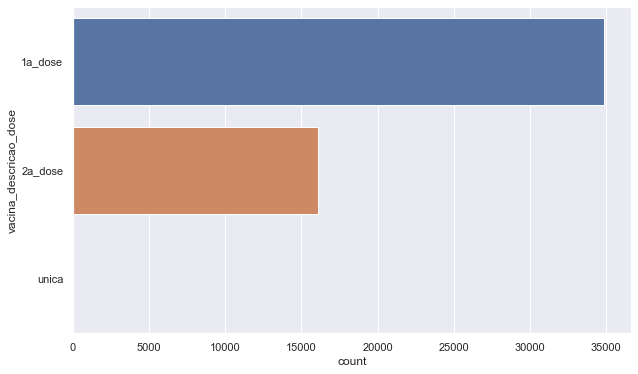

In [17]:
plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

array([[<AxesSubplot:title={'center':'1a_dose'}>,
        <AxesSubplot:title={'center':'2a_dose'}>],
       [<AxesSubplot:title={'center':'unica'}>, <AxesSubplot:>]],
      dtype=object)

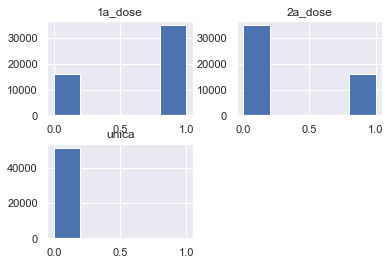

In [18]:
dummies.hist(bins=5)

In [19]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

In [21]:
df1 = df[['vacina_dataAplicacao', '1a_dose']]

In [28]:
df1.head(3)

,ds,y
0,2021-02-06 00:00:00+00:00,1
1,2021-03-06 00:00:00+00:00,0
2,2021-04-13 00:00:00+00:00,1


In [23]:
df1.columns = ['ds', 'y']

In [27]:
df1.head(3)

,ds,y
0,2021-02-06 00:00:00+00:00,1
1,2021-03-06 00:00:00+00:00,0
2,2021-04-13 00:00:00+00:00,1
